In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.625 # fraction plucked that becomes coarse
theta = 0.625 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

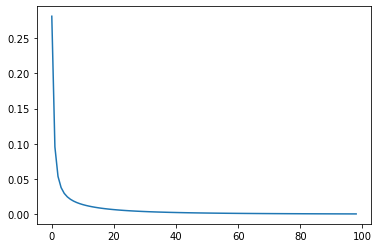

In [8]:
plt.plot(S)

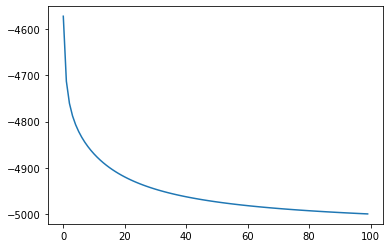

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0006105050668265904

In [11]:
eta

array([-4572.26492723, -4712.73277134, -4760.56374025, -4787.46514933,
       -4806.42955549, -4821.33223805, -4833.73929192, -4844.42491959,
       -4853.82912302, -4862.22847414, -4869.81040135, -4876.70943668,
       -4883.02654992, -4888.84022374, -4894.21318125, -4899.19667879,
       -4903.83336257, -4908.15924001, -4912.20508345, -4915.99745785,
       -4919.5594915 , -4922.9114665 , -4926.0712796 , -4929.05480797,
       -4931.87620365, -4934.5481337 , -4937.08197821, -4939.48799536,
       -4941.77546003, -4943.95278129, -4946.02760261, -4948.00688791,
       -4949.89699578, -4951.70374396, -4953.4324655 , -4955.08805794,
       -4956.67502654, -4958.19752233, -4959.65937591, -4961.06412728,
       -4962.41505249, -4963.71518738, -4964.96734883, -4966.17415373,
       -4967.33803615, -4968.46126264, -4969.54594618, -4970.59405864,
       -4971.60744213, -4972.58781933, -4973.53680273, -4974.45590317,
       -4975.34653755, -4976.21003584, -4977.04764753, -4977.86054752,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.27135073e+02, 2.86667229e+02, 2.38836260e+02, 2.11934851e+02,
       1.92970445e+02, 1.78067763e+02, 1.65660709e+02, 1.54975081e+02,
       1.45570878e+02, 1.37171526e+02, 1.29589599e+02, 1.22690564e+02,
       1.16373451e+02, 1.10559777e+02, 1.05186819e+02, 1.00203322e+02,
       9.55666380e+01, 9.12407606e+01, 8.71949171e+01, 8.34025427e+01,
       7.98405091e+01, 7.64885341e+01, 7.33287210e+01, 7.03451926e+01,
       6.75237969e+01, 6.48518669e+01, 6.23180223e+01, 5.99120052e+01,
       5.76245405e+01, 5.54472193e+01, 5.33723979e+01, 5.13931126e+01,
       4.95030048e+01, 4.76962566e+01, 4.59675351e+01, 4.43119426e+01,
       4.27249740e+01, 4.12024782e+01, 3.97406246e+01, 3.83358733e+01,
       3.69849481e+01, 3.56848132e+01, 3.44326517e+01, 3.32258468e+01,
       3.20619644e+01, 3.09387379e+01, 2.98540544e+01, 2.88059419e+01,
       2.77925584e+01, 2.68121812e+01, 2.58631978e+01, 2.49440974e+01,
       2.40534630e+01, 2.31899647e+01, 2.23523530e+01, 2.15394530e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_15.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_15.csv', alpha, delimiter = ',')